验证集，泛化误差，  验证泛化性能，或者进行模型选择

过拟合和欠拟合

无法提供足够的数据构成验证集时，可以使用K折交叉验证

训练数据集中的样本越少，我们就越有可能（且更严重地）过拟合。 随着训练数据量的增加，泛化误差通常会减小。 此外，一般来说，更多的数据不会有什么坏处。

通过多项式拟合来探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

生成数据集

因为是要对多项式进行拟合，因此同样需要用一个多项式来进行数据的生成，不妨令多项式为：
$$
y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6\frac{x^3}{3!} + \epsilon \text{ where } \epsilon \sim \mathcal{N}(0, 0.1^2)
$$

噪声项$\epsilon$服从均值为0且标准差为0.1的正态分布。
在优化的过程中，我们通常希望避免非常大的梯度值或损失值。这就是我们将特征从$x^i$调整为$\frac{x^i}{i!}$的原因，这样可以避免很大的$i$带来的特别大的指数值。我们将为训练集和测试集各生成100个样本。


In [2]:
max_degree = 20  # 多项式的最大阶数

# 真实的多项式只有3阶，但模型可以尝试用更高阶来拟合

n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间，用于存储真实的多项式系数
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])  # 只使用前4个系数，来表达数据生成多项式

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
# 生成特征，并随机打乱

# 计算对应的标签
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)! ， 除上对应的阶乘
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)  # 加上少量的高斯噪声

因为后续函数的操作需要时tensor类型，因此进行转换

In [ ]:
# NumPy ndarray转换为tensor
# 对列表中的每个变量 x（原先都是 NumPy ndarray）调用 torch.tensor(x, dtype=torch.float32)。
# 这里显式指定 dtype 为 torch.float32，确保生成的 Tensor 数据类型是 32 位浮点数，这也是深度学习中常用的数据类型。
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.5529],
         [ 0.4069]]),
 tensor([[ 1.0000e+00, -1.5529e+00,  1.2057e+00, -6.2413e-01,  2.4230e-01,
          -7.5254e-02,  1.9477e-02, -4.3208e-03,  8.3872e-04, -1.4472e-04,
           2.2473e-05, -3.1725e-06,  4.1055e-07, -4.9042e-08,  5.4398e-09,
          -5.6316e-10,  5.4658e-11, -4.9928e-12,  4.3074e-13, -3.5205e-14],
         [ 1.0000e+00,  4.0693e-01,  8.2794e-02,  1.1230e-02,  1.1425e-03,
           9.2981e-05,  6.3061e-06,  3.6659e-07,  1.8647e-08,  8.4310e-10,
           3.4308e-11,  1.2692e-12,  4.3038e-14,  1.3472e-15,  3.9157e-17,
           1.0623e-18,  2.7017e-20,  6.4669e-22,  1.4620e-23,  3.1311e-25]]),
 tensor([-4.4305,  5.2834]))

评估数据集上的损失

In [3]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 两项，分别表示损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())  # sum()返回所有元素的总和，numel()返回损失张量中元素的总数量
    return metric[0] / metric[1]

定义训练函数

通过保留每个样本的原始损失值，可以自定义后续处理方式
例如在evaluate_loss函数中，我们用累加手动计算平均损失
同时还能用于分析个体样本的情况

In [4]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')  # reduction='none'，表示不对损失进行降维操作，保留每个样本的损失值
    input_shape = train_features.shape[-1] # 获取训练特征的最后一个维度作为输入维度
    # 不设置偏置，因为我们已经在多项式中实现了它（多项式特征中的零次项）

    # 创建一个简单的神经网络，只包含一个线性层，从input_shape维度映射到1维输出，特别地，设置bias=False禁用偏置项
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])

    # 将数据打包为小批量
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    
    # 创建SGD优化器，用于更新模型参数
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)

    # 创建动画器对象，用于可视化训练过程
    # yscale='log'表示用对数刻度显示y轴，便于观察不同量级的损失变化
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    
    # 训练模型，迭代num_epochs次，每次迭代更新模型参数
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

尝试进行3阶多项式拟合

模型真实值w=[5,1.2,-3.4,5.6]

weight: [[ 4.982003   1.179627  -3.4143827  5.6188045]]


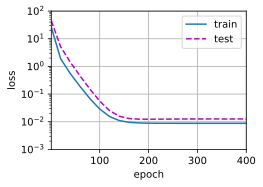

In [7]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

如果使用线性函数拟合，那么就会出现欠拟合的情况

weight: [[3.5856795 4.3249016]]


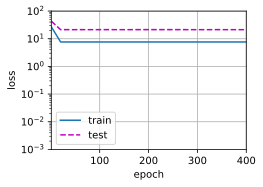

In [8]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

如果使用高阶函数进行拟合，那么相反，会出现过拟合的情况，因为模型会过于复杂

weight: [[ 4.948329    1.2328535  -3.2278593   5.3377595  -0.55265564  1.0321478
  -0.00652414 -0.06701989 -0.20770949 -0.23165427  0.20739904 -0.13684414
   0.21709982  0.1595807  -0.08240434 -0.12794001  0.17163347  0.02431145
  -0.09605601 -0.08638568]]


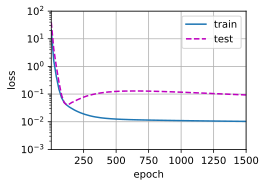

In [ ]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

# 可以发现，虽然训练误差逐渐减小，但是测试误差开始增加了